# Open Data From JSON

In [4]:
import pandas as pd
import numpy as np
import glob

In [5]:
path = 'crawl_json/'
frames = []
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.      
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        frames.append(pd.read_json(currentFile, orient='index'))

df = pd.concat(frames)
df.drop(['authors', 'image_url', 'localpath', 'title_page', 'title_rss'], axis = 1, inplace = True)
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url
0,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 14:58:03",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,"Denver Post poll: Most Coloradans support NRA,...",http://neighbors.denverpost.com/viewtopic.php?...
1,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 16:15:00",Neighbors » Forums » Sports News » Denver Bron...,en,neighbors.denverpost.com,Neighbors » Forums » Sports News » Denver Bron...,Elvis Dumervil agrees to contract with Baltimo...,http://neighbors.denverpost.com/viewtopic.php?...
2,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 15:43:08",Art historian Kelly Grovier looks at images th...,en,www.bbc.com,Art historian Kelly Grovier looks at images t...,BBC - Culture - The painting that tricks the eye,http://www.bbc.com/culture/story/20160304-the-...


# Preprocessing 

In [6]:
import re

In [7]:
# Remove punctuation
df['maintext_prepro'] = \
df['maintext'].map(lambda x: re.sub('[,\.!?]', '', x))
# To lowercase
df['maintext_prepro'] = \
df['maintext_prepro'].map(lambda x: x.lower())

In [8]:
import nltk
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
is_noun = lambda pos: pos[:2] == 'NN'
nouns = []

stemmer = WordNetLemmatizer()

df['tokenized_words'] = df['maintext'].apply(nltk.word_tokenize)

for element in df["tokenized_words"]:
        	nouns.append(" ".join([stemmer.lemmatize(word) for (word, pos) in nltk.pos_tag(element) if is_noun(pos) and len(word) > 2]))    # joined as a single string per article

df["maintext_nouns"] = nouns

In [10]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,maintext_prepro,tokenized_words,maintext_nouns
0,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 14:58:03",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,"Denver Post poll: Most Coloradans support NRA,...",http://neighbors.denverpost.com/viewtopic.php?...,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...
1,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 16:15:00",Neighbors » Forums » Sports News » Denver Bron...,en,neighbors.denverpost.com,Neighbors » Forums » Sports News » Denver Bron...,Elvis Dumervil agrees to contract with Baltimo...,http://neighbors.denverpost.com/viewtopic.php?...,neighbors » forums » sports news » denver bron...,"[Neighbors, », Forums, », Sports, News, », Den...",Neighbors Forums Sports News Denver Broncos Fo...
2,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 15:43:08",Art historian Kelly Grovier looks at images th...,en,www.bbc.com,Art historian Kelly Grovier looks at images t...,BBC - Culture - The painting that tricks the eye,http://www.bbc.com/culture/story/20160304-the-...,art historian kelly grovier looks at images t...,"[Art, historian, Kelly, Grovier, looks, at, im...",Art historian Kelly Grovier image frame trompe...


# Word Cloud

In [11]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Word Cloud All Words

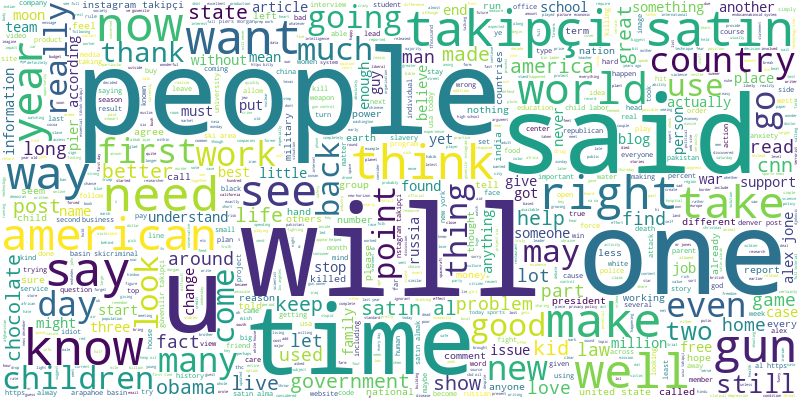

In [12]:
all_articles_string = ','.join(list(df['maintext_prepro'].values))
wordcloud.generate(all_articles_string)

wordcloud.to_image()

# Word Cloud Only Nouns

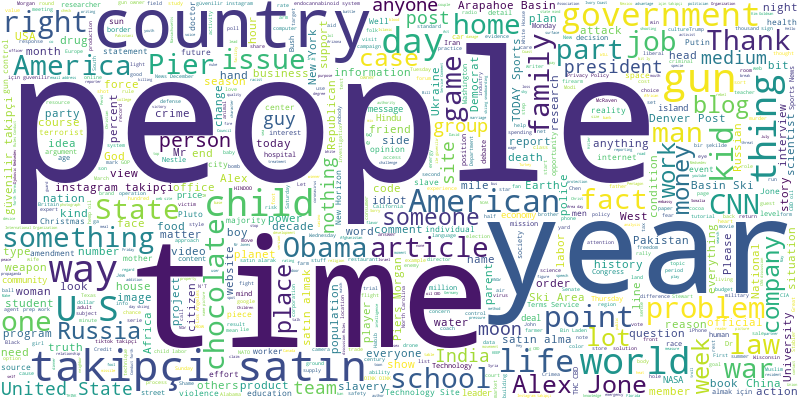

In [13]:
all_articles_nouns = ','.join(list(df['maintext_nouns'].values))
wordcloud.generate(all_articles_nouns)

wordcloud.to_image()

# Prepare data for LDA analysis

In [14]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])  #extend stopwords if desired

In [17]:
#Tokenize Text
def sentence_to_words(sentences):
    for sent in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(sent, deacc=True))

In [21]:
#Remove Stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if (word not in stop_words)] for doc in texts]    #filtering

In [23]:
maintext_data = df["maintext_nouns"].values.tolist()
df["maintext_ready"] = list(sentence_to_words(maintext_data))

df["maintext_ready"] = remove_stopwords(df["maintext_ready"].tolist())

In [24]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready
0,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 14:58:03",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,"Denver Post poll: Most Coloradans support NRA,...",http://neighbors.denverpost.com/viewtopic.php?...,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, artic..."
1,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 16:15:00",Neighbors » Forums » Sports News » Denver Bron...,en,neighbors.denverpost.com,Neighbors » Forums » Sports News » Denver Bron...,Elvis Dumervil agrees to contract with Baltimo...,http://neighbors.denverpost.com/viewtopic.php?...,neighbors » forums » sports news » denver bron...,"[Neighbors, », Forums, », Sports, News, », Den...",Neighbors Forums Sports News Denver Broncos Fo...,"[neighbors, forums, sports, news, denver, bron..."
2,"06/09/2021, 00:40:28","06/09/2021, 00:40:28","03/28/2020, 15:43:08",Art historian Kelly Grovier looks at images th...,en,www.bbc.com,Art historian Kelly Grovier looks at images t...,BBC - Culture - The painting that tricks the eye,http://www.bbc.com/culture/story/20160304-the-...,art historian kelly grovier looks at images t...,"[Art, historian, Kelly, Grovier, looks, at, im...",Art historian Kelly Grovier image frame trompe...,"[art, historian, kelly, grovier, image, frame,..."
